# Dependencies

In [1]:
import free_energy
import torch
import numpy as np
from importlib import reload
import texplot

import matplotlib.pyplot as plt
import matplotlib.colors as mpc
from matplotlib.pyplot import cm
import tqdm
from scipy.optimize import minimize
import matplotlib.ticker as ticker
from matplotlib.patches import Rectangle

# Marginal Likelihood Curve

In [ ]:
# Marginal Likelihood figure - CK
reload(free_energy)

n = 1000; 
lam = 0.5; gam = 0.1
samples = 10
gamma_l = 5; gamma_u = 1e-1
# gamma_range = np.logspace(-1,1,20)
dim_range = free_energy.intlogspace(np.log10(int(n/gamma_l)),np.log10(int(n/gamma_u)),20)
gamma_range = n/np.array(dim_range)
kernel='ck'
ck_dict = {}

L_list = [3, 6]
nl_list = ['tanh', 'gelu']


for L in L_list:
    for nl in nl_list:
        nl_func,b_sigma,a_sigma = free_energy.nonlin(nl,return_a=True)

        mean, ci = free_energy.empirical_energy_custom_welfords(iterations=samples, n=n, dims=dim_range, L=L, lam=[lam]*(len(dim_range)), gam=gam, 
                                                            b_sigma=b_sigma, a_sigma=a_sigma, kernel=kernel, 
                                                            nl_func=nl_func)   

        limit = []
        for gamma in tqdm.tqdm(gamma_range):
            limit.append(free_energy.limiting_energy(kernel=kernel, lam=lam, gam=gam, L=L, gamma=[gamma]*(L+1), 
                                            b_sigma=b_sigma, a_sigma=a_sigma, verbose=False))
            
        ck_dict[f'{nl}_{L}'] = {'mean': mean / n,
                            'ci': ci / n,
                            'limit': limit}
        
torch.save(ck_dict, 'arrays/ck_dict.pt')


20it [06:20, 19.04s/it]
100%|██████████| 20/20 [00:06<00:00,  2.94it/s]
20it [06:36, 19.81s/it]
100%|██████████| 20/20 [00:42<00:00,  2.12s/it]
20it [15:53, 47.68s/it] 
100%|██████████| 20/20 [00:38<00:00,  1.90s/it]
20it [16:15, 48.78s/it] 
100%|██████████| 20/20 [02:27<00:00,  7.39s/it]


In [ ]:
# Marginal Likelihood figure - NTK
reload(free_energy)

n = 1000; 
lam = 0.5; gam = 0.1
samples = 10
gamma_l = 5; gamma_u = 1e-1
# gamma_range = np.logspace(-1,1,20)
dim_range = free_energy.intlogspace(np.log10(int(n/gamma_l)),np.log10(int(n/gamma_u)),20)
gamma_range = n/np.array(dim_range)
kernel='ntk'
ntk_dict = {}

L_list = [3, 6]
nl_list = ['tanh', 'gelu']


for L in L_list:
    for nl in nl_list:
        nl_func,b_sigma,a_sigma = free_energy.nonlin(nl,return_a=True)

        mean, ci = free_energy.empirical_energy_custom_welfords(iterations=samples, n=n, dims=dim_range, L=L, lam=[lam]*(len(dim_range)), gam=gam, 
                                                            b_sigma=b_sigma, a_sigma=a_sigma, kernel=kernel, 
                                                            nl_func=nl_func, ntk_option=False)   

        limit = []
        for gamma in tqdm.tqdm(gamma_range):
            limit.append(free_energy.limiting_energy(kernel=kernel, lam=lam, gam=gam, L=L, gamma=[gamma]*(L+1), 
                                            b_sigma=b_sigma, a_sigma=a_sigma, verbose=False))
            
        ntk_dict[f'{nl}_{L}'] = {'mean': mean / n,
                            'ci': ci / n,
                            'limit': limit}
        
torch.save(ntk_dict, 'arrays/ntk_dict.pt')


20it [07:22, 22.10s/it]
100%|██████████| 20/20 [00:00<00:00, 123.83it/s]
20it [07:23, 22.19s/it]
100%|██████████| 20/20 [00:00<00:00, 39.99it/s]
20it [16:49, 50.46s/it] 
100%|██████████| 20/20 [00:00<00:00, 27.35it/s]
20it [17:05, 51.28s/it] 
100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


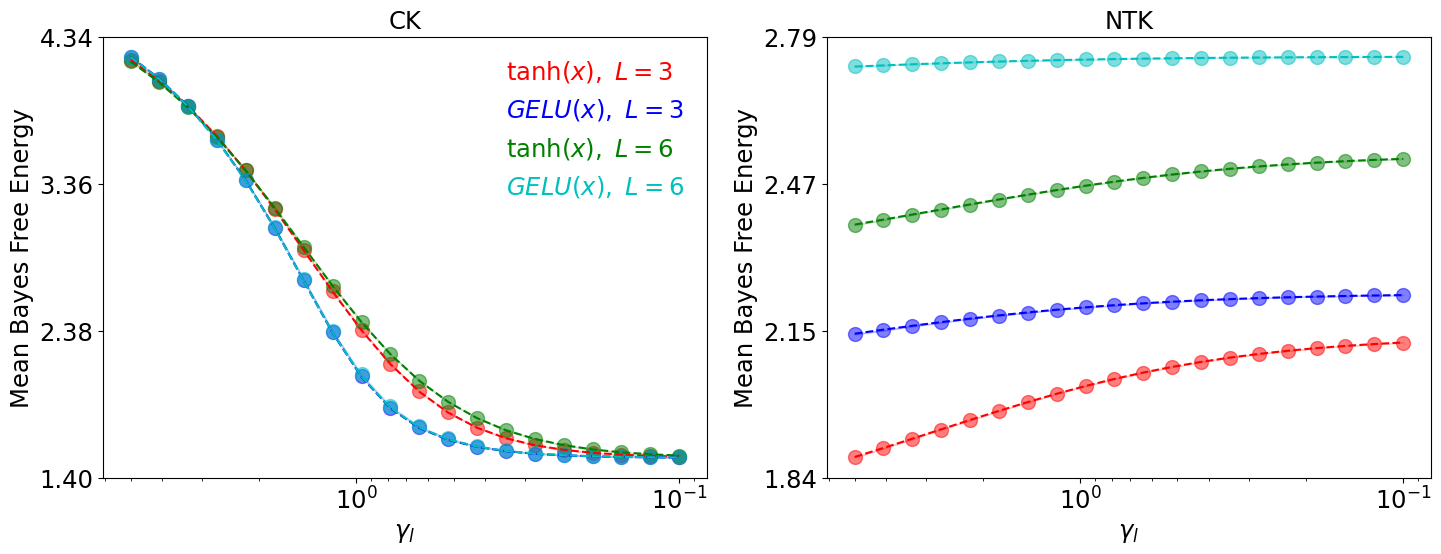

In [ ]:
from matplotlib.patches import Rectangle
import matplotlib.ticker as ticker

h, w, fs = 5, 14, 17.5
f, (ax1, ax2) = plt.subplots(1,2)
f.set_figheight(h)
f.set_figwidth(w)
f.tight_layout()
f.subplots_adjust(wspace=0.2)

colors = ['r','b','g','c']

## Axes 1 - CK

ck_dict = torch.load('arrays/ck_dict.pt')

for idx,key in enumerate(ck_dict.keys()):
    ax1.scatter(gamma_range, ck_dict[key]['mean'], color=colors[idx], marker='o', alpha=0.5, s=100, label='Empirical Energy')
    ci_l, ci_u = np.array(ck_dict[key]['mean']) - np.array(ck_dict[key]['ci']), np.array(ck_dict[key]['mean']) + np.array(ck_dict[key]['ci'])
    ax1.fill_between(gamma_range,ci_l, ci_u, alpha=0.2, color=colors[idx])
    ax1.plot(gamma_range, ck_dict[key]['limit'], color=colors[idx], linestyle='--', label='Limiting Energy')

## Axes 2 - NTK

ntk_dict = torch.load('arrays/ntk_dict.pt')

for idx,key in enumerate(ntk_dict.keys()):
    ax2.scatter(gamma_range, ntk_dict[key]['mean'], color=colors[idx], marker='o', alpha=0.5, s=100, label='Empirical Energy')
    ci_l, ci_u = np.array(ntk_dict[key]['mean']) - np.array(ntk_dict[key]['ci']), np.array(ntk_dict[key]['mean']) + np.array(ntk_dict[key]['ci'])
    ax2.fill_between(gamma_range,ci_l, ci_u, alpha=0.2, color=colors[idx])
    ax2.plot(gamma_range, ntk_dict[key]['limit'], color=colors[idx], linestyle='--', label='Limiting Energy')

ax1.set_xscale('log'); ax1.set_xlabel(r'$\gamma_l$', fontsize=fs)
ax1.xaxis.set_inverted(True)
ax1.set_ylabel(r'Mean Bayes Free Energy', fontsize=fs)

ax1.yaxis.set_major_locator(ticker.LinearLocator(4))
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))

ax2.set_xscale('log'); ax2.set_xlabel(r'$\gamma_l$', fontsize=fs)
ax2.xaxis.set_inverted(True)
ax2.set_ylabel(r'Mean Bayes Free Energy', fontsize=fs)

ax2.yaxis.set_major_locator(ticker.LinearLocator(4))
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))

ax1.tick_params(labelsize=fs)
ax2.tick_params(labelsize=fs)

ax1.set_title('CK', fontsize=fs)
ax2.set_title('NTK', fontsize=fs)

# Create custom legend entries
extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0, label=r"$\tanh(x),~L = 3$")
extra2 = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0, label=r'$GELU(x),~L = 3$')
extra3 = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0, label=r'$\tanh(x),~L = 6$')
extra4 = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0, label=r'$GELU(x),~L = 6$')

ax1.legend(handles=[extra,extra2,extra3,extra4], labelcolor=colors, loc = 'upper right', frameon=False, fontsize=fs)

# ax1.legend(labelcolor='k', loc = 'lower left', frameon=False)
leg = ax1.get_legend()
leg.legend_handles[0].set_facecolor('black')
leg.legend_handles[0].set_edgecolor('black')
leg.legend_handles[1].set_color('black')

plt.savefig(fname='graphics/meanfreeenergy.pdf', format='pdf', bbox_inches='tight')

# Strong Descent

In [ ]:
real_data_dict = {}

## Gaussian

In [ ]:
reload(free_energy)
n = 100
L = 3
# gam_list = [0.9,0.5,0.1,0.001]
gam = 0.1
samples = 10
data = [None]

gamma_range = np.logspace(-2,2,10)
dims = [int(n / gamma) for gamma in gamma_range]

nl_func,b_sigma, a_sigma = free_energy.nonlin(nl='tanh', return_a=True)
qq,rr,r = free_energy.ntk_constants(L,b_sigma,a_sigma)

real_data_dict = torch.load('arrays/real_data_dict.pt')

for inputdata in data:
    print(f'\n----- datatype: {inputdata} --------')

    energy_ck_mean = []
    energy_ck_ci = []

    energy_ck_lambda_mean = []
    energy_ck_lambda_ci = []

    energy_ntk_mean = []
    energy_ntk_ci = []

    energy_ntk_lambda_mean = []
    energy_ntk_lambda_ci = []


    # CK at lambda = lambda*
    # lam_opt = [ntk.opt_lambda(alpha=1, beta=0, gam=gam, c=1/gamma) for gamma in gamma_range] 
    lam_opt = [(1 / (1 - gam))]*(len(gamma_range))
    mean, ci = free_energy.empirical_energy_custom_welfords(iterations=samples, n=n, dims=dims, L=L, lam=lam_opt, gam=gam, 
                                                    b_sigma=b_sigma, a_sigma=a_sigma, kernel='ck', 
                                                    mX=inputdata, nl_func=nl_func)   
    energy_ck_mean.append(mean / n)
    energy_ck_ci.append(ci / n)

    # NTK at lambda = lambda*
    # lam_ntk = [ntk.opt_lambda(alpha=1, beta=0, gam=gam, c=1/gamma) for gamma in gamma_range] 
    lam_ntk = [(sum(rr)+1)/(1-gam)]*(len(gamma_range))
    mean, ci = free_energy.empirical_energy_custom_welfords(iterations=samples, n=n, dims=dims, L=L, lam=lam_ntk, gam=gam, 
                                                    b_sigma=b_sigma, a_sigma=a_sigma, kernel='ntk', 
                                                    mX=inputdata, nl_func=nl_func)   
    energy_ntk_mean.append(mean / n)
    energy_ntk_ci.append(ci / n)

    # CK at lambda = 0.01
    mean, ci = free_energy.empirical_energy_custom_welfords(iterations=samples, n=n, dims=dims, L=L, lam=[0.01]*(len(gamma_range)), gam=gam, 
                                                    b_sigma=b_sigma, a_sigma=a_sigma, kernel='ck', 
                                                    mX=inputdata, nl_func=nl_func)   
    energy_ck_lambda_mean.append(mean / n)
    energy_ck_lambda_ci.append(ci / n)

    # NTK at lambda = 0.01
    lam_ntk = (sum(rr)+1)/(1-gam)
    mean, ci = free_energy.empirical_energy_custom_welfords(iterations=samples, n=n, dims=dims, L=L, lam=[0.01]*(len(gamma_range)), gam=gam, 
                                                    b_sigma=b_sigma, a_sigma=a_sigma, kernel='ntk', 
                                                    mX=inputdata, nl_func=nl_func)   
    energy_ntk_lambda_mean.append(mean / n)
    energy_ntk_lambda_ci.append(ci / n)

    real_data_dict[inputdata] = {'ck_mean': energy_ck_mean,
                           'ck_ci': energy_ck_ci,
                           'ck_lambda_mean': energy_ck_lambda_mean,
                           'ck_lambda_ci': energy_ck_lambda_ci,
                           'ntk_mean': energy_ntk_mean,
                           'ntk_ci': energy_ntk_ci,
                           'ntk_lambda_mean': energy_ntk_lambda_mean,
                           'ntk_lambda_ci': energy_ntk_lambda_ci}
    
# torch.save(real_data_dict, 'arrays/real_data_dict.pt')



----- datatype: None --------


10it [01:27,  8.79s/it]
10it [01:34,  9.48s/it]
10it [01:26,  8.68s/it]
10it [01:29,  8.95s/it]


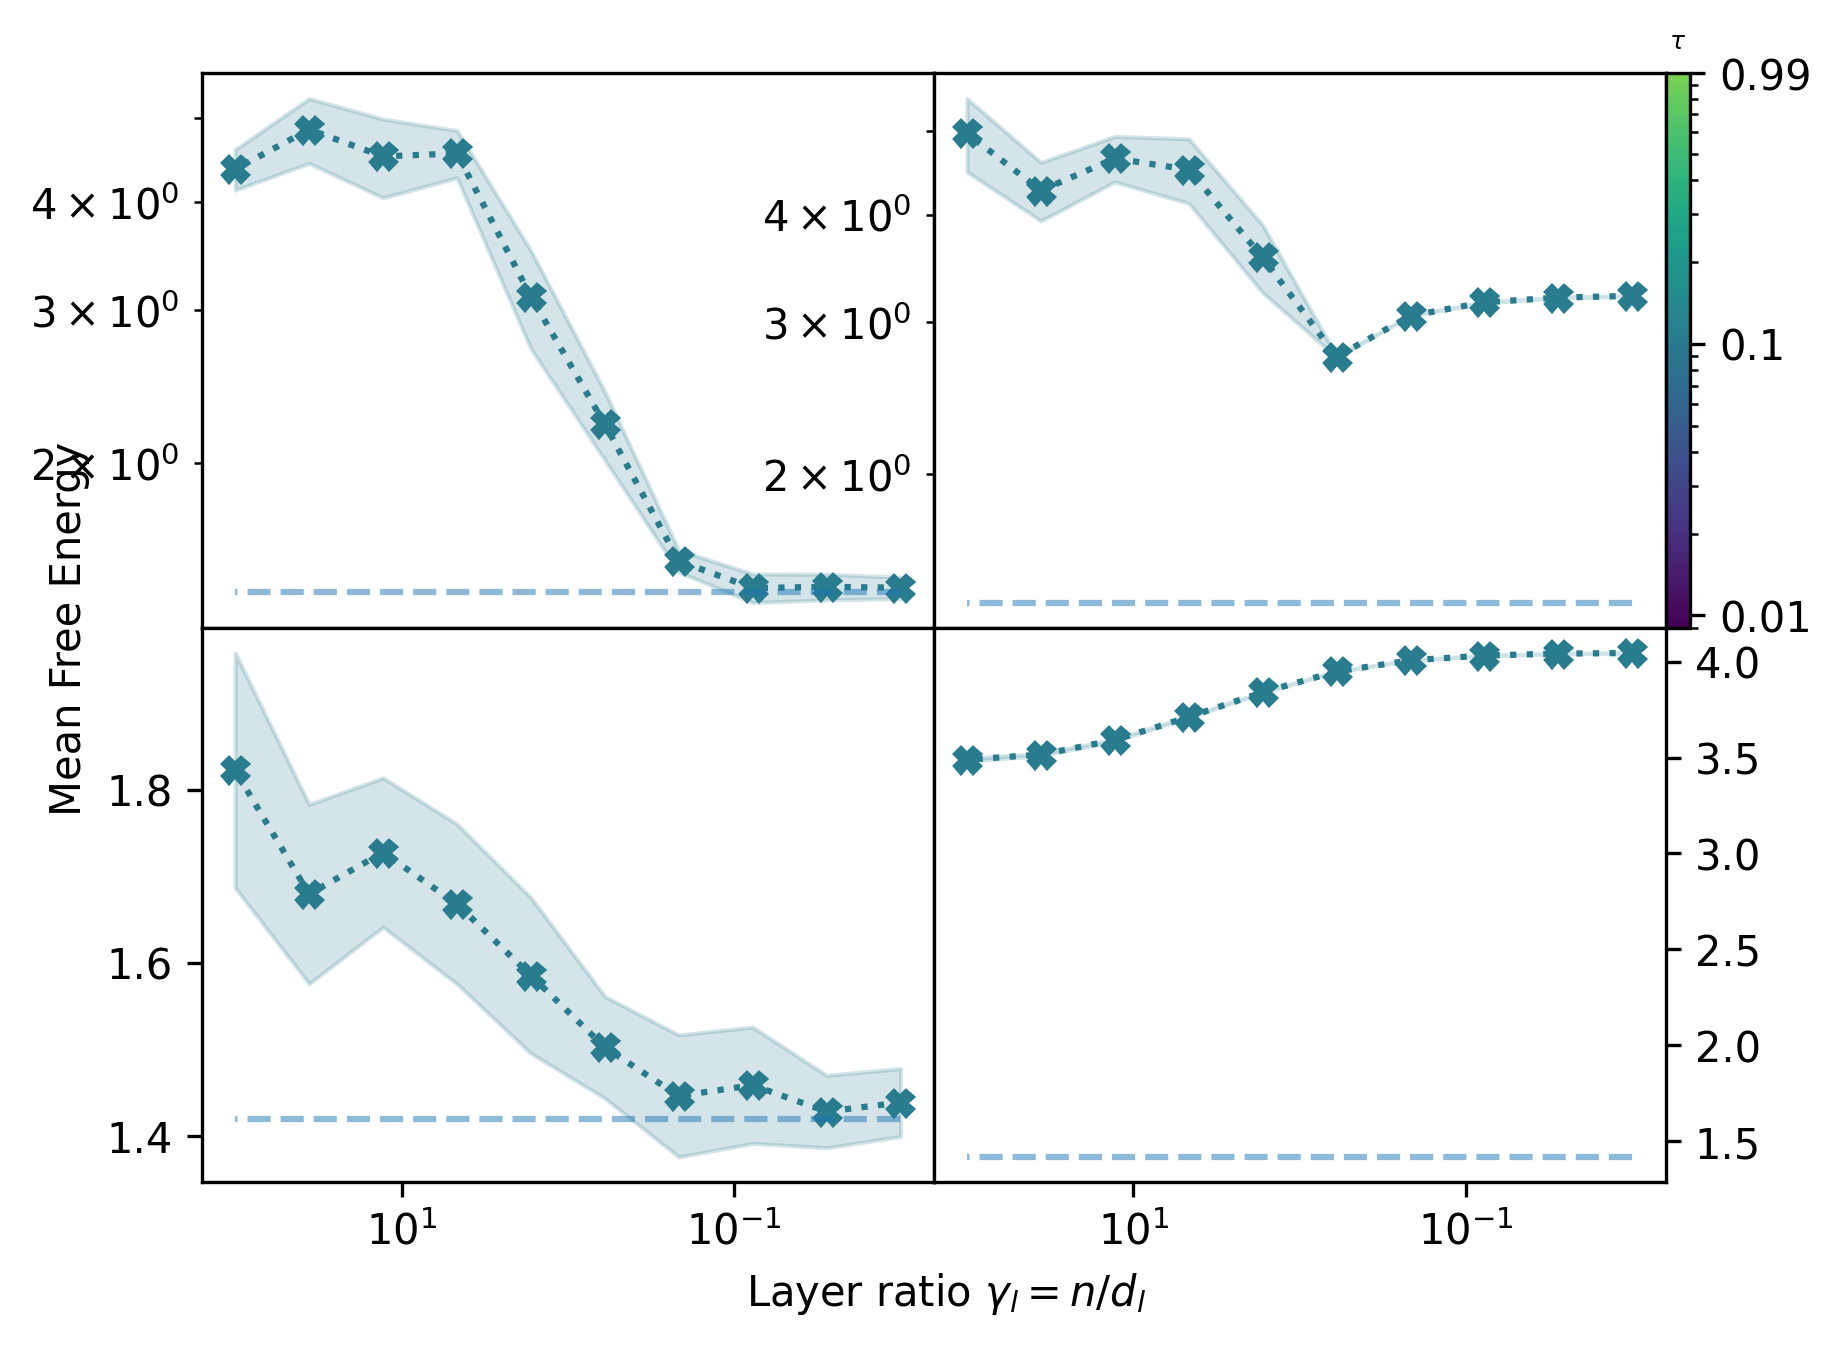

In [ ]:
fig = plt.figure(dpi=300,facecolor='white', figsize = (0.8*8,0.8*6))
gs = fig.add_gridspec(2,61, hspace = 0, wspace = 0)

ax0 = plt.subplot(gs[0,0:30])#sharex=True, sharey=True)
ax1 = plt.subplot(gs[0,30:60])#sharex=True, sharey=True)
ax2 = plt.subplot(gs[1,0:30])#sharex=True, sharey=True)
ax3 = plt.subplot(gs[1,30:60])#sharex=True, sharey=True)

gam_list = [gam]

gcolors = plt.cm.viridis(np.linspace(0,0.8,len(gam_list)))

v_cmap = mpc.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=plt.cm.viridis.name, a=0, b=0.8),
        plt.cm.viridis(np.linspace(0, 0.8, 256)))
norm = mpc.LogNorm(0.009,0.99)#vmin=min(linear),vmax=max(linear))
sm = plt.cm.ScalarMappable(cmap=v_cmap,
                               norm=norm)

g_groups_norm = norm(np.array(gam_list))
gcolors = sm.get_cmap()(g_groups_norm)

for idx, val in enumerate(gam_list):

    # CK at lambda = lambda*
    ax0.plot(gamma_range, energy_ck_mean[idx], marker='X', linestyle='dotted', color=gcolors[idx])
    ci_l, ci_u = np.array(energy_ck_mean[idx]) - np.array(energy_ck_ci[idx]), np.array(energy_ck_mean[idx]) + np.array(energy_ck_ci[idx])
    ax0.fill_between(gamma_range,ci_l, ci_u, alpha=0.2, color=gcolors[idx])
    ax0.hlines(y=(1+np.log(2*np.pi))/2,xmin=gamma_range[0],xmax=gamma_range[-1],linestyles='dashed',alpha=0.5)
    ax0.set_xscale('log')
    ax0.set_yscale('log')
    # ax0.set_xlabel('$\gamma_l = n/d_l$')
    # ax0.set_ylabel('Mean Free Energy')
    ax0.xaxis.set_inverted(True)

    # CK at lambda = 0.01
    ax1.plot(gamma_range, energy_ck_lambda_mean[idx], marker='X', linestyle='dotted', color=gcolors[idx])
    ci_l, ci_u = np.array(energy_ck_lambda_mean[idx]) - np.array(energy_ck_lambda_ci[idx]), np.array(energy_ck_lambda_mean[idx]) + np.array(energy_ck_lambda_ci[idx])
    ax1.fill_between(gamma_range,ci_l, ci_u, alpha=0.2, color=gcolors[idx])
    ax1.hlines(y=(1+np.log(2*np.pi))/2,xmin=gamma_range[0],xmax=gamma_range[-1],linestyles='dashed',alpha=0.5)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    # ax1.set_xlabel('$\gamma_l = n/d_l$')
    ax1.xaxis.set_inverted(True)
    ax1.yaxis.set_ticklabels([])

    # NTK at lambda = lambda*
    ax2.plot(gamma_range, energy_ntk_mean[idx], marker='X', linestyle='dotted', color=gcolors[idx])
    ci_l, ci_u = np.array(energy_ntk_mean[idx]) - np.array(energy_ntk_ci[idx]), np.array(energy_ntk_mean[idx]) + np.array(energy_ntk_ci[idx])
    ax2.fill_between(gamma_range,ci_l, ci_u, alpha=0.2, color=gcolors[idx])
    ax2.hlines(y=(1+np.log(2*np.pi))/2,xmin=gamma_range[0],xmax=gamma_range[-1],linestyles='dashed',alpha=0.5)
    ax2.set_xscale('log')
    # ax2.set_xlabel('$\gamma_l = n/d_l$')
    ax2.xaxis.set_inverted(True)

    # NTK at lambda = 0.01
    ax3.plot(gamma_range, energy_ntk_lambda_mean[idx], marker='X', linestyle='dotted', color=gcolors[idx])
    ci_l, ci_u = np.array(energy_ntk_lambda_mean[idx]) - np.array(energy_ntk_lambda_ci[idx]), np.array(energy_ntk_lambda_mean[idx]) + np.array(energy_ntk_lambda_ci[idx])
    ax3.fill_between(gamma_range,ci_l, ci_u, alpha=0.2, color=gcolors[idx])
    ax3.hlines(y=(1+np.log(2*np.pi))/2,xmin=gamma_range[0],xmax=gamma_range[-1],linestyles='dashed',alpha=0.5)
    ax3.set_xscale('log')
    # ax3.set_xlabel('$\gamma_l = n/d_l$')
    ax3.xaxis.set_inverted(True)
    ax3.yaxis.tick_right()

def no_scientific(x,pos):
    return str(x)
cbar = plt.colorbar(sm, format=ticker.FuncFormatter(no_scientific),
                ticks=[0.99,0.1,0.01], pad = -.025, cax = plt.subplot(gs[0,60]),
                    use_gridspec = True)
cbar.ax.set_title(r'$\tau$',fontsize = 6)

fig.add_subplot(111, frameon=False)

plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Layer ratio $\gamma_l = n/d_l$')
plt.ylabel('Mean Free Energy')
fig.savefig('graphics/strongdescentgaussian_(1).pdf', format='pdf')



## MNIST

In [ ]:
import torchvision
import torch 

mnist_set = torchvision.datasets.MNIST('./files/', train=True, download=True,
transform=torchvision.transforms.Compose([
torchvision.transforms.ToTensor(),
torchvision.transforms.Normalize(
(0.1307,), (0.3081,))
]))

mnist_set = list(mnist_set)
X = torch.cat([x[0].reshape(1,-1) for x in mnist_set],dim=0).numpy()
Y = torch.cat([torch.tensor(x[1]).reshape(1,-1)*1.0 for x in mnist_set],dim=0).numpy()
Y = Y[:,0] 

mX = X #np.load('mnist_x.npy')
mY = Y #np.load('mnist_y.npy')


In [ ]:
# Normalize by mean
mX = mX - mX.mean(axis=0) # Take mean of each feature across all data points (along coloumns),
mY = mY - mY.mean()
mY = mY / mY.std()
mX /= mX.std()

# Whitening covariance
Sigma = np.cov(mX.T)
D, V = np.linalg.eig(Sigma)
D = np.real(D)
V = np.real(V)
mX = (V @ np.diag(np.abs(D+1e-10)**(-0.5)) @ V.T) @ mX.T
mX = mX.T

# Remove dependent covariates
Z = np.diagonal(np.cov(mX.T))
mX = mX[:,Z > 0.95]

In [ ]:
reload(free_energy)
n = 175
L = 3
gam_list = [0.1]
samples = 30

gamma_range = np.logspace(np.log10(n / mX.shape[1]),2,10)

pbar = tqdm.tqdm(gam_list)

nl,b_sigma, a_sigma = free_energy.nonlin(nl='tanh', return_a=True)
qq,rr,r = free_energy.ntk_constants(L,b_sigma,a_sigma)

energy_ck_mean = []
energy_ck_ci = []

energy_ck_lambda_mean = []
energy_ck_lambda_ci = []

energy_ntk_mean = []
energy_ntk_ci = []

energy_ntk_lambda_mean = []
energy_ntk_lambda_ci = []

for gam in pbar:
    print(f'gam: {gam:.3}')

    # CK at lambda = lambda*
    # lam_opt = [ntk.opt_lambda(alpha=1, beta=0, gam=gam, c=1/gamma) for gamma in gamma_range]
    lam_opt = [1/(1-gam)]*(len(gamma_range)) 
    mean, ci = free_energy.empirical_energy_custom_welfords(iterations=samples, n=n, gamma=gamma_range, L=L, lam=lam_opt, gam=gam, 
                                                    b_sigma=b_sigma, a_sigma=a_sigma, kernel='ck', 
                                                    nl_name='tanh', mX=mX, mY=mY)   
    energy_ck_mean.append(mean / n)
    energy_ck_ci.append(ci / n)

    # NTK at lambda = lambda*
    lam_ntk = [(sum(rr)+1)/(1-gam)]*(len(gamma_range)) 
    mean, ci = free_energy.empirical_energy_custom_welfords(iterations=samples, n=n, gamma=gamma_range, L=L, lam=lam_ntk, gam=gam, 
                                                    b_sigma=b_sigma, a_sigma=a_sigma, kernel='ntk', 
                                                    nl_name='tanh', mX=mX, mY=mY)   
    energy_ntk_mean.append(mean / n)
    energy_ntk_ci.append(ci / n)

    # CK at lambda = 0.01
    mean, ci = free_energy.empirical_energy_custom_welfords(iterations=samples, n=n, gamma=gamma_range, L=L, lam=[0.01]*(len(gamma_range)), gam=gam, 
                                                    b_sigma=b_sigma, a_sigma=a_sigma, kernel='ck', 
                                                    nl_name='tanh', mX=mX, mY=mY)   
    energy_ck_lambda_mean.append(mean / n)
    energy_ck_lambda_ci.append(ci / n)

    # NTK at lambda = 0.01
    mean, ci = free_energy.empirical_energy_custom_welfords(iterations=samples, n=n, gamma=gamma_range, L=L, lam=[0.01]*(len(gamma_range)) , gam=gam, 
                                                    b_sigma=b_sigma, a_sigma=a_sigma, kernel='ntk', 
                                                    nl_name='tanh', mX=mX, mY=mY)   
    energy_ntk_lambda_mean.append(mean / n)
    energy_ntk_lambda_ci.append(ci / n)

real_data_dict['mnist'] = {'ck_mean': energy_ck_mean,
                           'ck_ci': energy_ck_ci,
                           'ck_lambda_mean': energy_ck_lambda_mean,
                           'ck_lambda_ci': energy_ck_lambda_ci,
                           'ntk_mean': energy_ntk_mean,
                           'ntk_ci': energy_ntk_ci,
                           'ntk_lambda_mean': energy_ntk_lambda_mean,
                           'ntk_lambda_ci': energy_ntk_lambda_ci}


  0%|          | 0/1 [00:00<?, ?it/s]

gam: 0.1


10it [03:35, 21.58s/it]
10it [03:36, 21.69s/it]
10it [03:36, 21.67s/it]
10it [03:35, 21.58s/it]
100%|██████████| 1/1 [14:25<00:00, 865.73s/it]


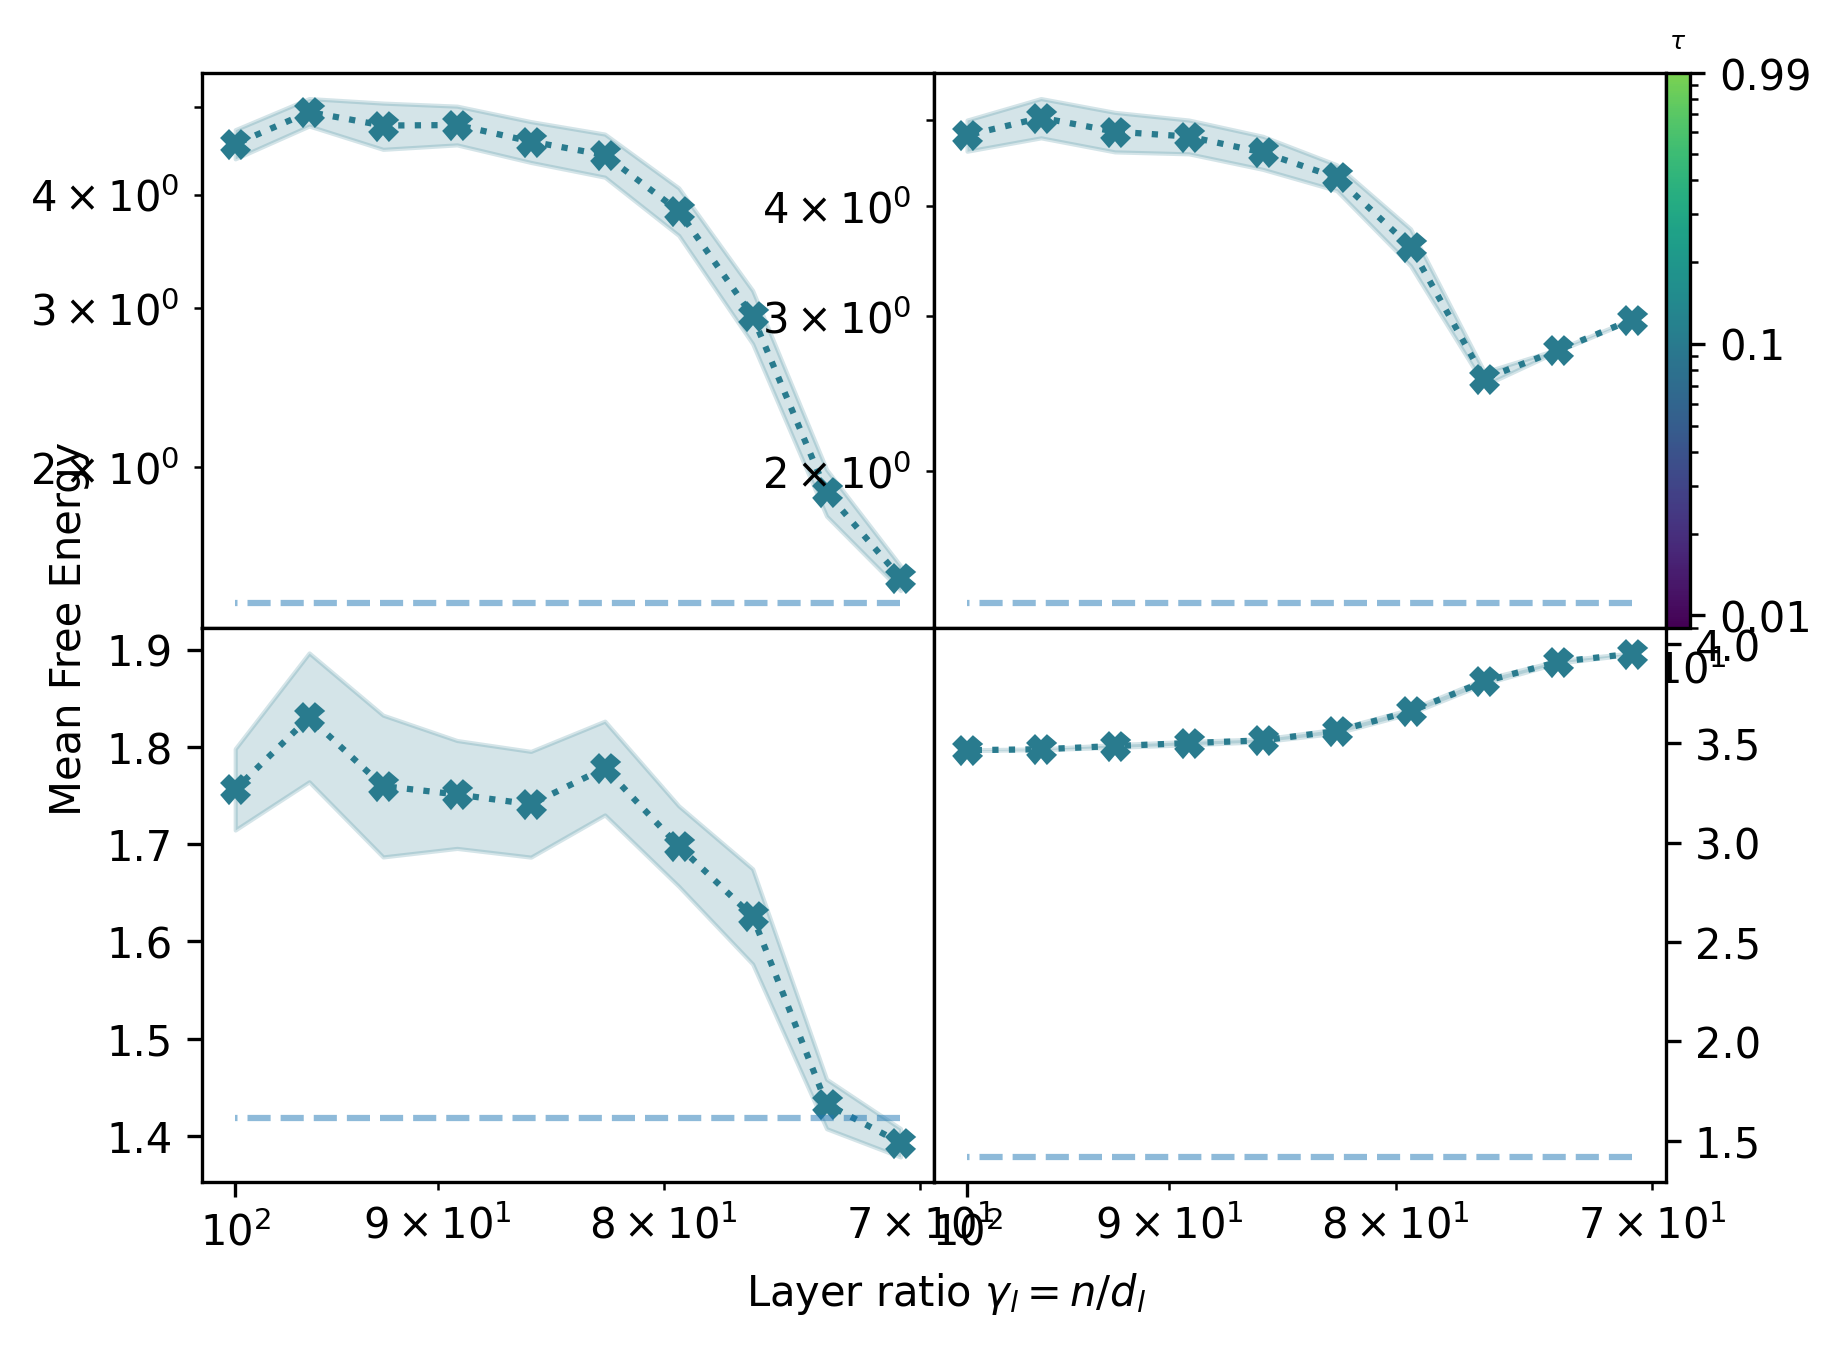

In [ ]:
fig = plt.figure(dpi=300,facecolor='white', figsize = (0.8*8,0.8*6))
gs = fig.add_gridspec(2,61, hspace = 0, wspace = 0)
gamma_range = np.logspace(np.log10(n / mX.shape[1]),2,10)
ax0 = plt.subplot(gs[0,0:30])#sharex=True, sharey=True)
ax1 = plt.subplot(gs[0,30:60])#sharex=True, sharey=True)
ax2 = plt.subplot(gs[1,0:30])#sharex=True, sharey=True)
ax3 = plt.subplot(gs[1,30:60])#sharex=True, sharey=True)

gcolors = plt.cm.viridis(np.linspace(0,0.8,len(gam_list)))

v_cmap = mpc.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=plt.cm.viridis.name, a=0, b=0.8),
        plt.cm.viridis(np.linspace(0, 0.8, 256)))
norm = mpc.LogNorm(0.009,0.99)#vmin=min(linear),vmax=max(linear))
sm = plt.cm.ScalarMappable(cmap=v_cmap,
                               norm=norm)

g_groups_norm = norm(np.array(gam_list))
gcolors = sm.get_cmap()(g_groups_norm)

for idx, val in enumerate(gam_list):

    # CK at lambda = lambda*
    ax0.plot(gamma_range, energy_ck_mean[idx], marker='X', linestyle='dotted', color=gcolors[idx])
    ci_l, ci_u = np.array(energy_ck_mean[idx]) - np.array(energy_ck_ci[idx]), np.array(energy_ck_mean[idx]) + np.array(energy_ck_ci[idx])
    ax0.fill_between(gamma_range,ci_l, ci_u, alpha=0.2, color=gcolors[idx])
    ax0.hlines(y=(1+np.log(2*np.pi))/2,xmin=gamma_range[0],xmax=gamma_range[-1],linestyles='dashed',alpha=0.5)
    ax0.set_xscale('log')
    ax0.set_yscale('log')
    # ax0.set_xlabel('$\gamma_l = n/d_l$')
    # ax0.set_ylabel('Mean Free Energy')
    ax0.xaxis.set_inverted(True)

    # CK at lambda = 0.01
    ax1.plot(gamma_range, energy_ck_lambda_mean[idx], marker='X', linestyle='dotted', color=gcolors[idx])
    ci_l, ci_u = np.array(energy_ck_lambda_mean[idx]) - np.array(energy_ck_lambda_ci[idx]), np.array(energy_ck_lambda_mean[idx]) + np.array(energy_ck_lambda_ci[idx])
    ax1.fill_between(gamma_range,ci_l, ci_u, alpha=0.2, color=gcolors[idx])
    ax1.hlines(y=(1+np.log(2*np.pi))/2,xmin=gamma_range[0],xmax=gamma_range[-1],linestyles='dashed',alpha=0.5)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    # ax1.set_xlabel('$\gamma_l = n/d_l$')
    ax1.xaxis.set_inverted(True)
    ax1.yaxis.set_ticklabels([])

    # NTK at lambda = lambda*
    ax2.plot(gamma_range, energy_ntk_mean[idx], marker='X', linestyle='dotted', color=gcolors[idx])
    ci_l, ci_u = np.array(energy_ntk_mean[idx]) - np.array(energy_ntk_ci[idx]), np.array(energy_ntk_mean[idx]) + np.array(energy_ntk_ci[idx])
    ax2.fill_between(gamma_range,ci_l, ci_u, alpha=0.2, color=gcolors[idx])
    ax2.hlines(y=(1+np.log(2*np.pi))/2,xmin=gamma_range[0],xmax=gamma_range[-1],linestyles='dashed',alpha=0.5)
    ax2.set_xscale('log')
    # ax2.set_xlabel('$\gamma_l = n/d_l$')
    ax2.xaxis.set_inverted(True)

    # NTK at lambda = 0.01
    ax3.plot(gamma_range, energy_ntk_lambda_mean[idx], marker='X', linestyle='dotted', color=gcolors[idx])
    ci_l, ci_u = np.array(energy_ntk_lambda_mean[idx]) - np.array(energy_ntk_lambda_ci[idx]), np.array(energy_ntk_lambda_mean[idx]) + np.array(energy_ntk_lambda_ci[idx])
    ax3.fill_between(gamma_range,ci_l, ci_u, alpha=0.2, color=gcolors[idx])
    ax3.hlines(y=(1+np.log(2*np.pi))/2,xmin=gamma_range[0],xmax=gamma_range[-1],linestyles='dashed',alpha=0.5)
    ax3.set_xscale('log')
    # ax3.set_xlabel('$\gamma_l = n/d_l$')
    ax3.xaxis.set_inverted(True)
    ax3.yaxis.tick_right()

def no_scientific(x,pos):
    return str(x)
cbar = plt.colorbar(sm, format=ticker.FuncFormatter(no_scientific),
                ticks=[0.99,0.1,0.01], pad = -.025, cax = plt.subplot(gs[0,60]),
                    use_gridspec = True)
cbar.ax.set_title(r'$\tau$',fontsize = 6)

fig.add_subplot(111, frameon=False)

plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Layer ratio $\gamma_l = n/d_l$')
plt.ylabel('Mean Free Energy')
fig.savefig('graphics/strongdescentmnist.pdf', format='pdf')



## CIFAR-10

In [ ]:
import torchvision
import torch 

cifar_set = torchvision.datasets.CIFAR10('./files/', train=True, download=True,
transform=torchvision.transforms.Compose([
torchvision.transforms.ToTensor()
]))

cifar_set = list(cifar_set)
cX = torch.cat([x[0].reshape(1,-1) for x in cifar_set],dim=0).numpy()
cY = torch.cat([torch.tensor(x[1]).reshape(1,-1)*1.0 for x in cifar_set],dim=0).numpy()
cY = cY[:,0]

# Normalize by mean
cX = cX - cX.mean(axis=0)
cY = cY - cY.mean()
cY = cY / cY.std()
cX /= cX.std(axis=0)

# Normalize covariance
Sigma = np.cov(cX.T)
D, V = np.linalg.eig(Sigma)
D = np.real(D)
V = np.real(V)
cX = (V @ np.diag(np.abs(D+1e-10)**(-0.5)) @ V.T) @ cX.T
cX = cX.T
# Remove dependent covariates
Z = np.diagonal(np.cov(cX.T))
cX = cX[:,Z > 0.95] 

Files already downloaded and verified


In [ ]:
reload(free_energy)
n = 300
L = 3
gam_list = [0.1]
samples = 30

gamma_range = np.logspace(-1,2,10)

pbar = tqdm.tqdm(gam_list)

nl,b_sigma, a_sigma = free_energy.nonlin(nl='tanh', return_a=True)
qq,rr,r = free_energy.ntk_constants(L,b_sigma,a_sigma)

energy_ck_mean = []
energy_ck_ci = []

energy_ck_lambda_mean = []
energy_ck_lambda_ci = []

energy_ntk_mean = []
energy_ntk_ci = []

energy_ntk_lambda_mean = []
energy_ntk_lambda_ci = []

for gam in pbar:
    print(f'gam: {gam:.3}')

    # CK at lambda = lambda*
    # lam_opt = [ntk.opt_lambda(alpha=1, beta=0, gam=gam, c=1/gamma) for gamma in gamma_range]
    lam_opt = [1/(1-gam)]*(len(gamma_range)) 
    mean, ci = free_energy.empirical_energy_custom_welfords(iterations=samples, n=n, gamma=gamma_range, L=L, lam=lam_opt, gam=gam, 
                                                    b_sigma=b_sigma, a_sigma=a_sigma, kernel='ck', 
                                                    nl_name='tanh', mX=cX, mY=cY)   
    energy_ck_mean.append(mean / n)
    energy_ck_ci.append(ci / n)

    # NTK at lambda = lambda*
    lam_ntk = [(sum(rr)+1)/(1-gam)]*(len(gamma_range)) 
    mean, ci = free_energy.empirical_energy_custom_welfords(iterations=samples, n=n, gamma=gamma_range, L=L, lam=lam_ntk, gam=gam, 
                                                    b_sigma=b_sigma, a_sigma=a_sigma, kernel='ntk', 
                                                    nl_name='tanh', mX=cX, mY=cY)   
    energy_ntk_mean.append(mean / n)
    energy_ntk_ci.append(ci / n)

    # CK at lambda = 0.01
    mean, ci = free_energy.empirical_energy_custom_welfords(iterations=samples, n=n, gamma=gamma_range, L=L, lam=[0.01]*(len(gamma_range)), gam=gam, 
                                                    b_sigma=b_sigma, a_sigma=a_sigma, kernel='ck', 
                                                    nl_name='tanh', mX=cX, mY=cY)   
    energy_ck_lambda_mean.append(mean / n)
    energy_ck_lambda_ci.append(ci / n)

    # NTK at lambda = 0.01
    mean, ci = free_energy.empirical_energy_custom_welfords(iterations=samples, n=n, gamma=gamma_range, L=L, lam=[0.01]*(len(gamma_range)) , gam=gam, 
                                                    b_sigma=b_sigma, a_sigma=a_sigma, kernel='ntk', 
                                                    nl_name='tanh', mX=cX, mY=cY)   
    energy_ntk_lambda_mean.append(mean / n)
    energy_ntk_lambda_ci.append(ci / n)

real_data_dict['cifar'] = {'gamma_range': gamma_range,
                           'ck_mean': energy_ck_mean,
                           'ck_ci': energy_ck_ci,
                           'ck_lambda_mean': energy_ck_lambda_mean,
                           'ck_lambda_ci': energy_ck_lambda_ci,
                           'ntk_mean': energy_ntk_mean,
                           'ntk_ci': energy_ntk_ci,
                           'ntk_lambda_mean': energy_ntk_lambda_mean,
                           'ntk_lambda_ci': energy_ntk_lambda_ci}


  0%|          | 0/1 [00:00<?, ?it/s]

gam: 0.1


10it [04:14, 25.46s/it]
10it [04:19, 26.00s/it]
10it [04:07, 24.76s/it]
10it [04:09, 24.92s/it]
100%|██████████| 1/1 [16:51<00:00, 1011.97s/it]


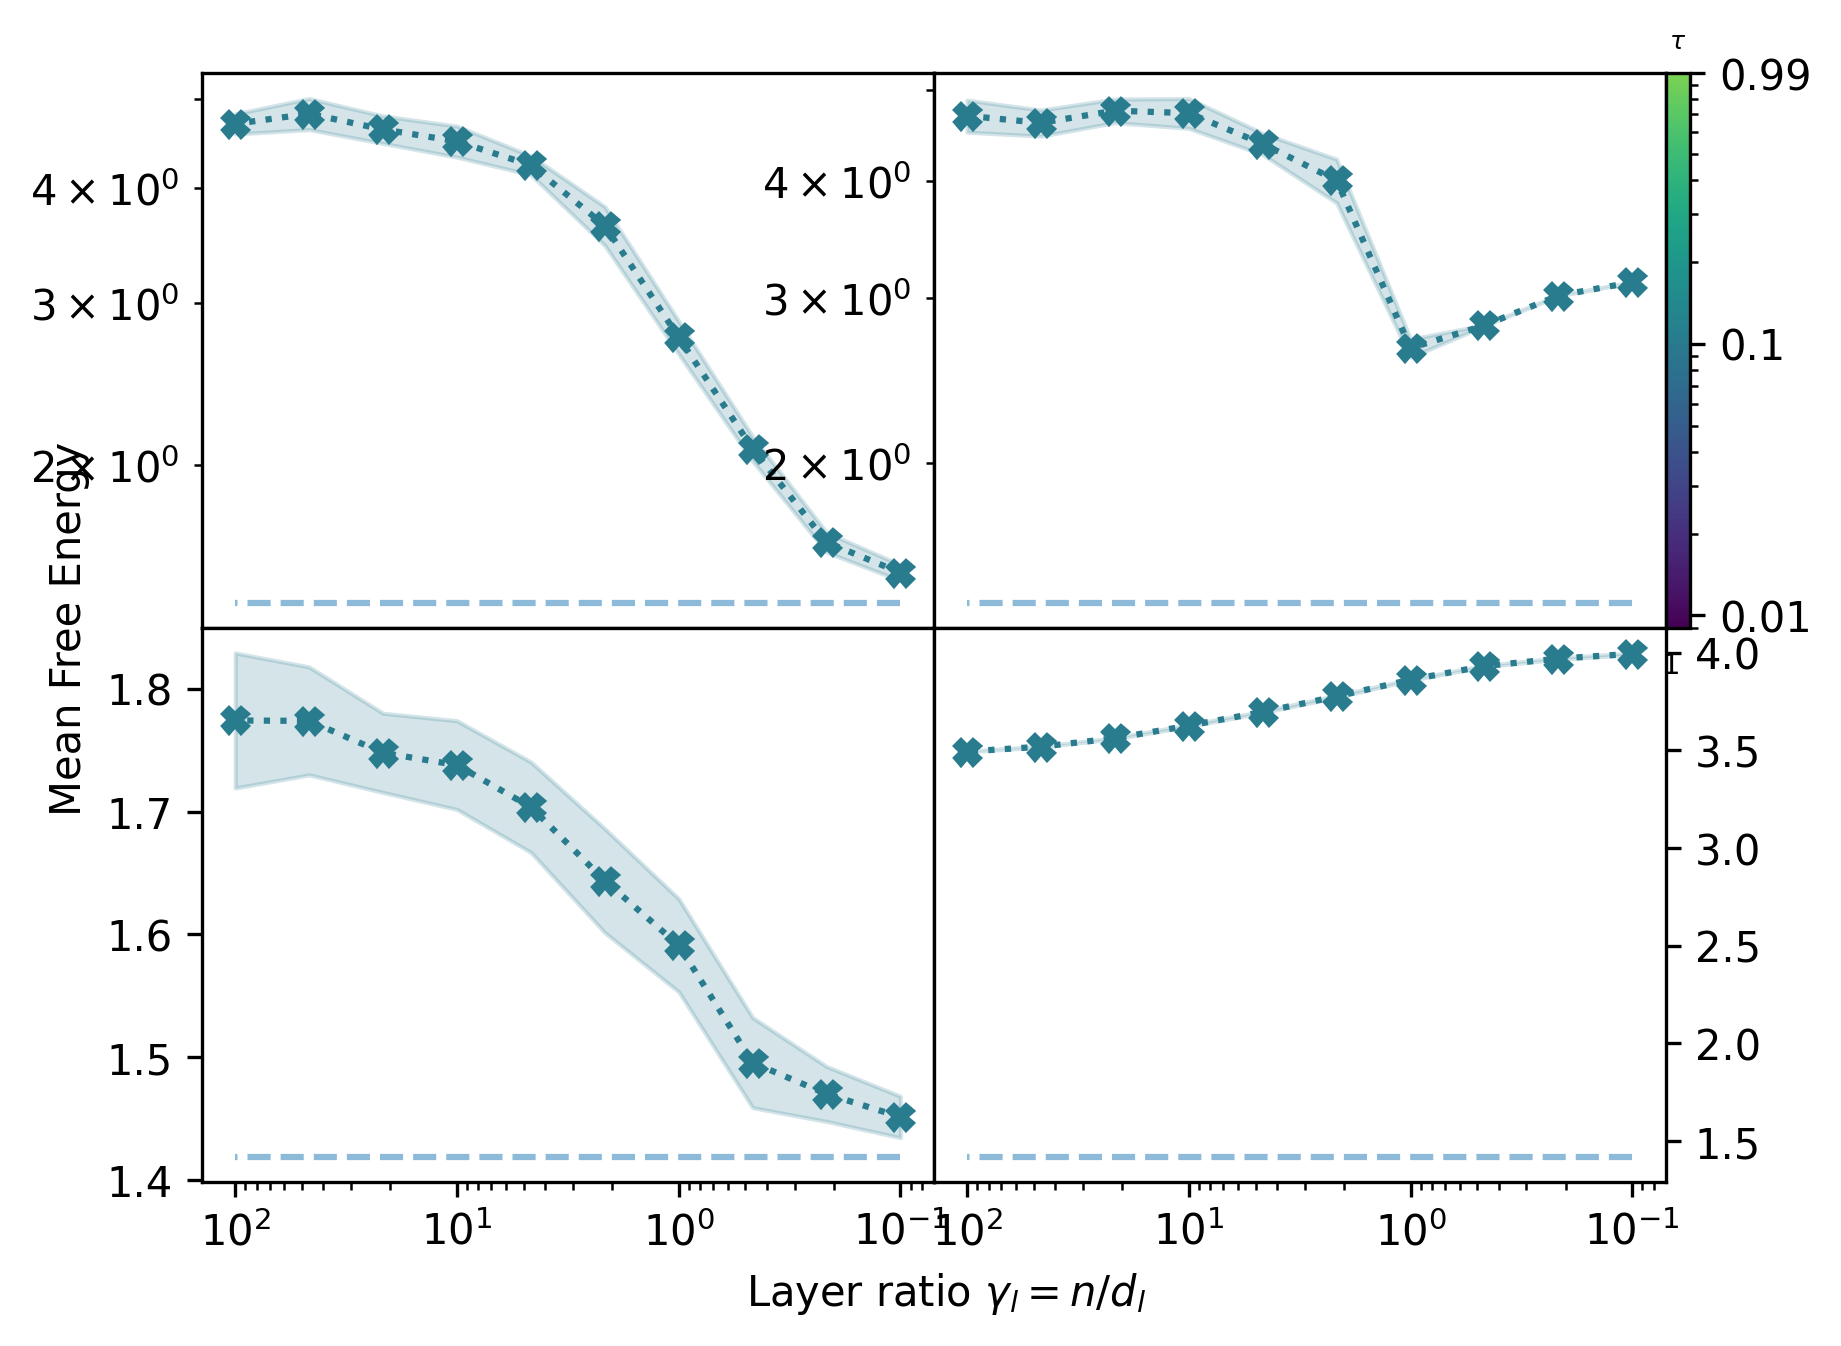

In [ ]:
fig = plt.figure(dpi=300,facecolor='white', figsize = (0.8*8,0.8*6))
gs = fig.add_gridspec(2,61, hspace = 0, wspace = 0)

ax0 = plt.subplot(gs[0,0:30])#sharex=True, sharey=True)
ax1 = plt.subplot(gs[0,30:60])#sharex=True, sharey=True)
ax2 = plt.subplot(gs[1,0:30])#sharex=True, sharey=True)
ax3 = plt.subplot(gs[1,30:60])#sharex=True, sharey=True)

gcolors = plt.cm.viridis(np.linspace(0,0.8,len(gam_list)))

v_cmap = mpc.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=plt.cm.viridis.name, a=0, b=0.8),
        plt.cm.viridis(np.linspace(0, 0.8, 256)))
norm = mpc.LogNorm(0.009,0.99)#vmin=min(linear),vmax=max(linear))
sm = plt.cm.ScalarMappable(cmap=v_cmap,
                               norm=norm)

g_groups_norm = norm(np.array(gam_list))
gcolors = sm.get_cmap()(g_groups_norm)

for idx, val in enumerate(gam_list):

    # CK at lambda = lambda*
    ax0.plot(gamma_range, energy_ck_mean[idx], marker='X', linestyle='dotted', color=gcolors[idx])
    ci_l, ci_u = np.array(energy_ck_mean[idx]) - np.array(energy_ck_ci[idx]), np.array(energy_ck_mean[idx]) + np.array(energy_ck_ci[idx])
    ax0.fill_between(gamma_range,ci_l, ci_u, alpha=0.2, color=gcolors[idx])
    ax0.hlines(y=(1+np.log(2*np.pi))/2,xmin=gamma_range[0],xmax=gamma_range[-1],linestyles='dashed',alpha=0.5)
    ax0.set_xscale('log')
    ax0.set_yscale('log')
    # ax0.set_xlabel('$\gamma_l = n/d_l$')
    # ax0.set_ylabel('Mean Free Energy')
    ax0.xaxis.set_inverted(True)

    # CK at lambda = 0.01
    ax1.plot(gamma_range, energy_ck_lambda_mean[idx], marker='X', linestyle='dotted', color=gcolors[idx])
    ci_l, ci_u = np.array(energy_ck_lambda_mean[idx]) - np.array(energy_ck_lambda_ci[idx]), np.array(energy_ck_lambda_mean[idx]) + np.array(energy_ck_lambda_ci[idx])
    ax1.fill_between(gamma_range,ci_l, ci_u, alpha=0.2, color=gcolors[idx])
    ax1.hlines(y=(1+np.log(2*np.pi))/2,xmin=gamma_range[0],xmax=gamma_range[-1],linestyles='dashed',alpha=0.5)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    # ax1.set_xlabel('$\gamma_l = n/d_l$')
    ax1.xaxis.set_inverted(True)
    ax1.yaxis.set_ticklabels([])

    # NTK at lambda = lambda*
    ax2.plot(gamma_range, energy_ntk_mean[idx], marker='X', linestyle='dotted', color=gcolors[idx])
    ci_l, ci_u = np.array(energy_ntk_mean[idx]) - np.array(energy_ntk_ci[idx]), np.array(energy_ntk_mean[idx]) + np.array(energy_ntk_ci[idx])
    ax2.fill_between(gamma_range,ci_l, ci_u, alpha=0.2, color=gcolors[idx])
    ax2.hlines(y=(1+np.log(2*np.pi))/2,xmin=gamma_range[0],xmax=gamma_range[-1],linestyles='dashed',alpha=0.5)
    ax2.set_xscale('log')
    # ax2.set_xlabel('$\gamma_l = n/d_l$')
    ax2.xaxis.set_inverted(True)

    # NTK at lambda = 0.01
    ax3.plot(gamma_range, energy_ntk_lambda_mean[idx], marker='X', linestyle='dotted', color=gcolors[idx])
    ci_l, ci_u = np.array(energy_ntk_lambda_mean[idx]) - np.array(energy_ntk_lambda_ci[idx]), np.array(energy_ntk_lambda_mean[idx]) + np.array(energy_ntk_lambda_ci[idx])
    ax3.fill_between(gamma_range,ci_l, ci_u, alpha=0.2, color=gcolors[idx])
    ax3.hlines(y=(1+np.log(2*np.pi))/2,xmin=gamma_range[0],xmax=gamma_range[-1],linestyles='dashed',alpha=0.5)
    ax3.set_xscale('log')
    # ax3.set_xlabel('$\gamma_l = n/d_l$')
    ax3.xaxis.set_inverted(True)
    ax3.yaxis.tick_right()

def no_scientific(x,pos):
    return str(x)
cbar = plt.colorbar(sm, format=ticker.FuncFormatter(no_scientific),
                ticks=[0.99,0.1,0.01], pad = -.025, cax = plt.subplot(gs[0,60]),
                    use_gridspec = True)
cbar.ax.set_title(r'$\tau$',fontsize = 6)

fig.add_subplot(111, frameon=False)

plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Layer ratio $\gamma_l = n/d_l$')
plt.ylabel('Mean Free Energy')
fig.savefig('graphics/strongdescentcifar10.pdf', format='pdf')



## Plot

In [ ]:
real_data_dict = torch.load('arrays/real_data_dict.pt')
gamma_range = np.logspace(-1,2,10)

with texplot.theme():

    fig = plt.figure(dpi=300,facecolor='white', figsize = (0.8*8,0.8*6))
    gs = fig.add_gridspec(2,61, hspace = 0, wspace = 0)

    fontsize = 14

    ax0 = plt.subplot(gs[0,0:30])#sharex=True, sharey=True)
    ax1 = plt.subplot(gs[0,30:60])#sharex=True, sharey=True)
    ax2 = plt.subplot(gs[1,0:30])#sharex=True, sharey=True)
    ax3 = plt.subplot(gs[1,30:60])#sharex=True, sharey=True)

    colors = ['green', 'blue', 'red', 'cyan']
    names = {'mnist': 'MNIST',
            'cifar': 'CIFAR-10',
            None : 'Gaussian'}

    for idx, key in enumerate(real_data_dict.keys()):
        if key == 'teacher':
            continue

        # CK at lambda = lambda*
        ax0.plot(gamma_range, real_data_dict[key]['ck_mean'][0], marker='X', linestyle='dotted', color=colors[idx], label=names[key])
        ci_l, ci_u = np.array(real_data_dict[key]['ck_mean'][0]) - np.array(real_data_dict[key]['ck_ci'][0]), np.array(real_data_dict[key]['ck_mean'][0]) + np.array(real_data_dict[key]['ck_ci'][0])
        ax0.fill_between(gamma_range,ci_l, ci_u, alpha=0.2, color=colors[idx])
        ax0.hlines(y=(1+np.log(2*np.pi))/2,xmin=gamma_range[0],xmax=gamma_range[-1],linestyles='dashed',alpha=0.5)
        ax0.set_xscale('log')
        # ax0.set_yscale('log')
        # ax0.set_xlabel('$\gamma_l = n/d_l$')
        # ax0.set_ylabel('Mean Free Energy')
        ax0.xaxis.set_inverted(True)
        ax0.yaxis.set_major_locator(ticker.MaxNLocator(3))
        ax0.set_title("$\lambda = \lambda^*$", fontsize=fontsize)

        # CK at lambda = 0.01
        ax1.plot(gamma_range, real_data_dict[key]['ck_lambda_mean'][0], marker='X', linestyle='dotted', color=colors[idx])
        ci_l, ci_u = np.array(real_data_dict[key]['ck_lambda_mean'][0]) - np.array(real_data_dict[key]['ck_lambda_ci'][0]), np.array(real_data_dict[key]['ck_lambda_mean'][0]) + np.array(real_data_dict[key]['ck_lambda_ci'][0])
        ax1.fill_between(gamma_range,ci_l, ci_u, alpha=0.2, color=colors[idx])
        ax1.hlines(y=(1+np.log(2*np.pi))/2,xmin=gamma_range[0],xmax=gamma_range[-1],linestyles='dashed',alpha=0.5)
        ax1.set_xscale('log')
        # ax1.set_yscale('log')
        # ax1.set_xlabel('$\gamma_l = n/d_l$')
        ax1.xaxis.set_inverted(True)
        
        ax1.yaxis.set_ticklabels([])
        ax1.set_ylabel('CK', fontsize=fontsize)
        ax1.set_title("$\lambda = 0.01$", fontsize=fontsize)
        

        # NTK at lambda = lambda*
        ax2.plot(gamma_range, real_data_dict[key]['ntk_mean'][0], marker='X', linestyle='dotted', color=colors[idx])
        ci_l, ci_u = np.array(real_data_dict[key]['ntk_mean'][0]) - np.array(real_data_dict[key]['ntk_ci'][0]), np.array(real_data_dict[key]['ntk_mean'][0]) + np.array(real_data_dict[key]['ntk_ci'][0])
        ax2.fill_between(gamma_range,ci_l, ci_u, alpha=0.2, color=colors[idx])
        ax2.hlines(y=(1+np.log(2*np.pi))/2,xmin=gamma_range[0],xmax=gamma_range[-1],linestyles='dashed',alpha=0.5)
        ax2.set_xscale('log')
        # ax2.set_xlabel('$\gamma_l = n/d_l$')
        ax2.xaxis.set_inverted(True)
        ax2.yaxis.set_major_locator(ticker.MaxNLocator(3))
        ax2.xaxis.set_major_locator(ticker.FixedLocator([0.1, 1, 10, 100]))
        # ax2.xaxis.set_major_locator(ticker.LogLocator(numticks=3))
        ax2.xaxis.set_minor_locator(ticker.NullLocator())

        # NTK at lambda = 0.01
        ax3.plot(gamma_range, real_data_dict[key]['ntk_lambda_mean'][0], marker='X', linestyle='dotted', color=colors[idx])
        ci_l, ci_u = np.array(real_data_dict[key]['ntk_lambda_mean'][0]) - np.array(real_data_dict[key]['ntk_lambda_ci'][0]), np.array(real_data_dict[key]['ntk_lambda_mean'][0]) + np.array(real_data_dict[key]['ntk_lambda_ci'][0])
        ax3.fill_between(gamma_range,ci_l, ci_u, alpha=0.2, color=colors[idx])
        ax3.hlines(y=(1+np.log(2*np.pi))/2,xmin=gamma_range[0],xmax=gamma_range[-1],linestyles='dashed',alpha=0.5)
        ax3.set_xscale('log')
        # ax3.set_xlabel('$\gamma_l = n/d_l$')
        ax3.xaxis.set_inverted(True)
        ax3.yaxis.tick_right()
        ax3.yaxis.set_major_locator(ticker.MaxNLocator(3))
        ax3.set_ylabel('NTK', fontsize=fontsize)
        ax3.xaxis.set_minor_locator(ticker.NullLocator())
        ax3.xaxis.set_major_locator(ticker.FixedLocator([0.1, 1, 10, 100]))
        


    fig.add_subplot(111, frameon=False)

    h, l = ax0.get_legend_handles_labels()

    leg = ax3.legend(handles=h[-3:], fontsize=fontsize, frameon=False, loc='lower right')

    # leg.legend_handles[0].set_color('black')
    # leg.legend_handles[1].set_color('black')

    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel('Layer ratio $\gamma_l = n/d_l$', labelpad=2, fontsize=fontsize)
    plt.ylabel('Mean Free Energy', labelpad=15, fontsize=fontsize)
    fig.savefig('graphics/strongdescent_realdata.pdf', format='pdf')



# Weak & Strong Descent Heatmap

### Weak Descent

In [ ]:
from matplotlib.colors import LogNorm

# CK
s = 100
tau_range = np.logspace(-3,3,s)
lam_range = np.logspace(-3,3,s)
wd_ck = np.empty((s,s))
wd_ntk = np.empty((s,s))

L = 3; nl = 'tanh'
_,b_sigma,a_sigma = free_energy.nonlin(nl=nl,return_a=True)

for idx, tau in enumerate(tau_range):
    for idy, lam in enumerate(lam_range):
        ck_diff = free_energy.ck_limiting('small',lam,tau) - free_energy.ck_limiting('large',lam,tau)
        ntk_diff = free_energy.ntk_limiting(type='small',lam=lam,gam=tau,L=L,b_sigma=b_sigma,a_sigma=a_sigma) - free_energy.ntk_limiting(type='large',lam=lam,gam=tau,L=L,b_sigma=b_sigma,a_sigma=a_sigma)
        wd_ck[idx,idy] = (1 if ck_diff < 0 else -1)
        wd_ntk[idx,idy] = (1 if ntk_diff < 0 else -1)

torch.save(wd_ck, 'arrays/wd_ck.pt')
torch.save(wd_ntk, 'arrays/wd_ntk.pt')
torch.save(tau_range, 'arrays/wd_tau.pt')
torch.save(lam_range, 'arrays/wd_lam.pt')

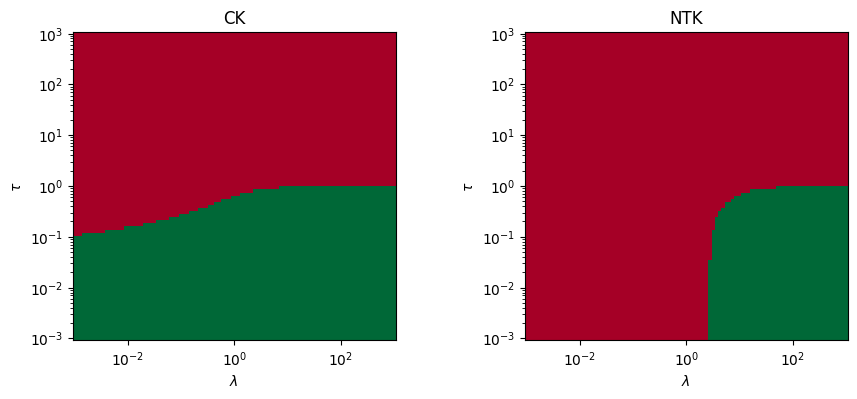

In [ ]:
wd_ck = torch.load('arrays/wd_ck.pt')
wd_ntk = torch.load('arrays/wd_ntk.pt')

f, (ax0,ax1) = plt.subplots(1,2)
f.subplots_adjust(wspace=0.4)
f.set_figheight(4)
f.set_figwidth(10)

c = ax0.pcolor(tau_range, lam_range, wd_ck, shading='auto', cmap='RdYlGn')
ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_title('CK')
ax0.set_xlabel('$\lambda$')
ax0.set_ylabel(r'$\tau$')

c = ax1.pcolor(tau_range, lam_range, wd_ntk, shading='auto', cmap='RdYlGn')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title('NTK')
ax1.set_xlabel('$\lambda$')
ax1.set_ylabel(r'$\tau$')

f.savefig(fname='graphics/weak_descent_heatmap.png', format='png')

### Strong Descent

100%|██████████| 100/100 [00:26<00:00,  3.78it/s]
30it [2:40:18, 320.61s/it]


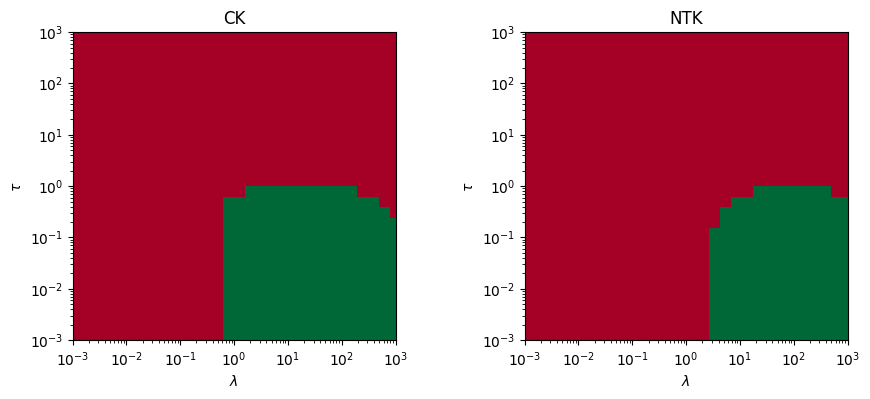

In [ ]:
reload(free_energy)

s = 30
tau_range = np.logspace(-3,3,s)
lam_range = np.logspace(-3,3,s)
gamma_range = np.logspace(-5,5,100)

sd_ck = np.empty((s,s))
sd_ntk = np.empty((s,s))

L = 3; nl = 'tanh'
nl_func,b_sigma,a_sigma = free_energy.nonlin(nl,return_a=True)

for idx, tau in tqdm.tqdm(enumerate(tau_range)):
    for idy, lam in enumerate(lam_range):
        limit_ck = []
        limit_ntk = []
        for gamma in tqdm.tqdm(gamma_range):
            limit_ck.append(free_energy.limiting_energy(kernel='ck', lam=lam, gam=tau, L=L, gamma=[gamma]*(L+1), 
                                            b_sigma=b_sigma, a_sigma=a_sigma, verbose=False))
            limit_ntk.append(free_energy.limiting_energy(kernel='ntk', lam=lam, gam=tau, L=L, gamma=[gamma]*(L+1), 
                                            b_sigma=b_sigma, a_sigma=a_sigma, verbose=False))
        sd_ck[idx,idy] = (1 if free_energy.ck_limiting(type='small',lam=lam,gam=tau) < np.array(limit_ck).min() else -1)
        sd_ntk[idx,idy] = (1 if free_energy.ntk_limiting(type='small',lam=lam,gam=tau, L=L, b_sigma=b_sigma, a_sigma=a_sigma) < np.array(limit_ntk).min() else -1)

torch.save(sd_ck, 'arrays/sd_ck.pt')
torch.save(sd_ntk, 'arrays/sd_ntk.pt')
torch.save(tau_range, 'arrays/sd_tau.pt')
torch.save(lam_range, 'arrays/sd_lam.pt')

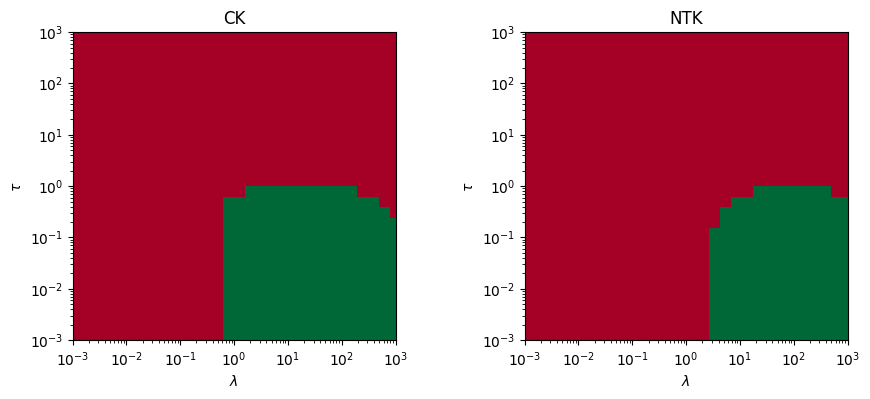

In [ ]:
sd_ck = torch.load('arrays/sd_ck.pt')
sd_ntk = torch.load('arrays/sd_ntk.pt')

f, (ax0,ax1) = plt.subplots(1,2)
f.subplots_adjust(wspace=0.4)
f.set_figheight(4)
f.set_figwidth(10)

c = ax0.pcolor(tau_range, lam_range, sd_ck, shading='auto', cmap='RdYlGn')
ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_xlim([tau_range[0],tau_range[-1]])
ax0.set_ylim([lam_range[0],lam_range[-1]])
ax0.set_title('CK')
ax0.set_xlabel('$\lambda$')
ax0.set_ylabel(r'$\tau$')

c = ax1.pcolor(tau_range, lam_range, sd_ntk, shading='auto', cmap='RdYlGn')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim([tau_range[0],tau_range[-1]])
ax1.set_ylim([lam_range[0],lam_range[-1]])
ax1.set_title('NTK')
ax1.set_xlabel('$\lambda$')
ax1.set_ylabel(r'$\tau$')

f.savefig(fname='graphics/strong_descent_heatmap.pdf', format='pdf')

### Plot

In [102]:
sd_ck = torch.load('arrays/sd_ck.pt')
sd_ntk = torch.load('arrays/sd_ntk.pt')
sd_tau = torch.load('arrays/sd_tau.pt')
sd_lam = torch.load('arrays/sd_lam.pt')

wd_ck = torch.load('arrays/wd_ck.pt')
wd_ntk = torch.load('arrays/wd_ntk.pt')
wd_tau = torch.load('arrays/wd_tau.pt')
wd_lam = torch.load('arrays/wd_lam.pt')

wd_ntk *= 0.75
wd_ck *= 0.5

with texplot.theme():
    fontsize = 24
    f, ((ax0,ax1),(ax2,ax3)) = plt.subplots(2,2, sharex=True, sharey=True)
    f.subplots_adjust(wspace=0, hspace=0)
    f.set_figheight(8)
    f.set_figwidth(10)

    c = ax0.pcolor(sd_tau, sd_lam, sd_ck, shading='nearest', cmap='RdYlGn', alpha=1)
    ax0.set_xscale('log')
    ax0.set_yscale('log')
    ax0.set_xlim([sd_tau[0],sd_tau[-1]])
    ax0.set_ylim([sd_lam[0],sd_lam[-1]])
    ax0.set_title('CK', fontsize=fontsize)
    ax0.set_ylabel(r'$\tau$', fontsize=fontsize)
    ax0.grid(False)
    ax0.xaxis.set_minor_locator(ticker.NullLocator())
    ax0.yaxis.set_minor_locator(ticker.NullLocator())
    ax0.tick_params(labelsize=int(fontsize * 0.75))

    c = ax1.pcolor(sd_tau, sd_lam, sd_ntk, shading='nearest', cmap='RdYlGn', alpha=1)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlim([sd_tau[0],sd_tau[-1]])
    ax1.set_ylim([sd_lam[0],sd_lam[-1]])
    ax1.set_title('NTK', fontsize=fontsize)
    ax1.grid(False)
    ax1.xaxis.set_minor_locator(ticker.NullLocator())
    ax1.yaxis.set_minor_locator(ticker.NullLocator())
    ax1.tick_params(labelsize=int(fontsize * 0.75))

    c = ax2.pcolor(wd_tau, wd_lam, wd_ck, shading='nearest', cmap='RdYlGn', alpha=1)
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlim([wd_tau[0],wd_tau[-1]])
    ax2.set_ylim([wd_lam[0],wd_lam[-1]])
    ax2.set_xlabel('$\lambda$', fontsize=fontsize)
    ax2.set_ylabel(r'$\tau$', fontsize=fontsize)
    ax2.grid(False)
    ax2.xaxis.set_minor_locator(ticker.NullLocator())
    ax2.yaxis.set_minor_locator(ticker.NullLocator())
    ax2.tick_params(labelsize=int(fontsize * 0.75))

    c = ax3.pcolor(wd_tau, wd_lam, wd_ntk, shading='auto', cmap='RdYlGn', alpha=1)
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.set_xlim([wd_tau[0],wd_tau[-1]])
    ax3.set_ylim([wd_lam[0],wd_lam[-1]])
    ax3.set_xlabel('$\lambda$', fontsize=fontsize)
    ax3.grid(False)
    ax3.xaxis.set_minor_locator(ticker.NullLocator())
    ax3.yaxis.set_minor_locator(ticker.NullLocator())
    ax3.tick_params(labelsize=int(fontsize * 0.75))

    # f.tight_layout()
    # ax3.xaxis.set_ticklabels(torch.logspace(-3, 3, 7).tolist())
    ax0.yaxis.set_major_locator(ticker.FixedLocator(torch.logspace(-3, 3, 4).tolist()))
    ax2.yaxis.set_major_locator(ticker.FixedLocator(torch.logspace(-3, 1, 3).tolist()))
    
    ax2.xaxis.set_major_locator(ticker.FixedLocator(torch.logspace(-3, 3, 4).tolist()))
    ax3.xaxis.set_major_locator(ticker.FixedLocator(torch.logspace(-1, 3, 3).tolist()))

    f.savefig(fname='graphics/strong_weak_descent_heatmap.png', format='png')
    f.show()


# BFE After Training

In [63]:
# Marginal Likelihood figure - NTK
reload(free_energy)

data = [None, 'teacher']
network_mean = True
log_det_only = False
data_fit_only = False
ntk_option = True

n = 150; 
gam = 1e-3
samples = 11

dim_range = [50, 100, 200]
gamma_range = n/np.array(dim_range)

L = 2
nl = 'tanh'

num_epochs = 11
epochs_list = np.linspace(0,200,num_epochs)
lr = 0.5

nl_func,b_sigma,a_sigma = free_energy.nonlin(nl,return_a=True)
qq,rr,r = free_energy.ntk_constants(L,b_sigma,a_sigma)

result_dict = {}

for inputdata in data:
    print(f'\n----- datatype: {inputdata} --------')
    ntk_mean = np.empty((num_epochs,len(dim_range)))
    ntk_ci = np.empty((num_epochs,len(dim_range)))
    ck_mean = np.empty((num_epochs,len(dim_range)))
    ck_ci = np.empty((num_epochs,len(dim_range)))

    for idx,epochs in tqdm.tqdm(enumerate(epochs_list)):
        kernel='ntk'
        if inputdata is None:
            lam_ntk = [(sum(rr)+1)/(1-gam)]*(len(gamma_range))
        else:
            lam_ntk = [1]*len(dim_range)
        mean, ci = free_energy.empirical_energy_custom_welfords(iterations=samples, n=n, dims=dim_range, L=L, lam=lam_ntk, gam=gam, 
                                                            b_sigma=b_sigma, a_sigma=a_sigma, kernel=kernel, 
                                                            mX=inputdata,
                                                            trace_approx=False, epochs=int(epochs), lr=lr,
                                                            nl_func=nl_func, ntk_option=ntk_option, verbose=False,
                                                            network_mean=network_mean, log_det_only=log_det_only, data_fit_only=data_fit_only)   
            
        ntk_mean[idx,:] = mean / n
        ntk_ci[idx,:] = ci / n
        
        kernel='ck'
        if inputdata is None:
            lam_ck = [(1 / (1 - gam))]*(len(gamma_range))
        else:
            lam_ck = [1]*len(dim_range)
        mean, ci = free_energy.empirical_energy_custom_welfords(iterations=samples, n=n, dims=dim_range, L=L, lam=lam_ck, gam=gam, 
                                                            b_sigma=b_sigma, a_sigma=a_sigma, kernel=kernel, 
                                                            mX=inputdata,
                                                            trace_approx=False, epochs=int(epochs), lr=lr,
                                                            nl_func=nl_func, ntk_option=ntk_option, verbose=False,
                                                            network_mean=network_mean, log_det_only=log_det_only, data_fit_only=data_fit_only)   

        ck_mean[idx,:] = mean / n
        ck_ci[idx,:] = ci / n

    result_dict[inputdata] = {'ntk_mean': ntk_mean,
                              'ntk_ci': ntk_ci,
                              'ck_mean': ck_mean,
                              'ck_ci': ck_ci}



----- datatype: None --------


3it [00:01,  1.82it/s]
3it [00:01,  2.63it/s]
3it [00:02,  1.40it/s]
3it [00:02,  1.38it/s]
3it [00:03,  1.05s/it]
3it [00:03,  1.07s/it]
3it [00:04,  1.35s/it]
3it [00:04,  1.36s/it]
3it [00:05,  1.88s/it]
3it [00:04,  1.64s/it]
3it [00:07,  2.63s/it]
3it [00:23,  7.83s/it]
3it [00:25,  8.65s/it]
3it [00:25,  8.48s/it]
3it [00:27,  9.15s/it]
3it [00:27,  9.24s/it]
3it [00:29,  9.81s/it]
3it [00:29,  9.84s/it]
3it [00:30, 10.25s/it]
3it [00:32, 10.77s/it]
3it [00:32, 10.78s/it]]
3it [00:32, 10.79s/it]
11it [05:56, 32.44s/it]



----- datatype: teacher --------


3it [00:15,  5.20s/it]
3it [00:15,  5.12s/it]
3it [00:17,  5.83s/it]
3it [00:17,  5.71s/it]
3it [00:18,  6.24s/it]
3it [00:19,  6.42s/it]
3it [00:20,  6.79s/it]
3it [00:20,  6.88s/it]
3it [00:22,  7.44s/it]
3it [00:22,  7.51s/it]
3it [00:24,  8.05s/it]
3it [00:23,  8.00s/it]
3it [00:25,  8.63s/it]
3it [00:25,  8.54s/it]
3it [00:26,  8.97s/it]
3it [00:27,  9.09s/it]
3it [00:28,  9.60s/it]
3it [00:29,  9.68s/it]
3it [00:30, 10.13s/it]
3it [00:31, 10.35s/it]
3it [00:31, 10.65s/it]]
3it [00:37, 12.39s/it]
11it [08:51, 48.35s/it]


## Plot

In [110]:
from matplotlib.patches import Rectangle
import matplotlib.ticker as ticker

with texplot.theme():

    h, w, fs, s = 9, 16, 30, 75
    f, (ax) = plt.subplots(len(data),2, sharex=True)
    f.set_figheight(h)
    f.set_figwidth(w)
    # f.tight_layout()
    f.subplots_adjust(wspace=0.17, hspace=0.1)

    colors = ['r','b','g','c']

    dim_range = [50, 100, 200]
    gamma_range = n/np.array(dim_range)

    for id, key in enumerate(result_dict.keys()):
        # Set window
        x1, x2, y1, y2 = 40, 210, result_dict[key]['ck_mean'].min() - 0.1, result_dict[key]['ck_mean'][-1,:].max() + 0.5  # subregion of the original image
        axins = ax[id][0].inset_axes(
                [0.4, 0.4, 0.55, 0.55],
                xlim=(x1, x2), ylim=(y1, y2))
        axins.xaxis.set_major_locator(ticker.FixedLocator(locs=[200, 50]))
        axins.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,g}"))

        axins.yaxis.set_major_locator(ticker.LinearLocator(4))
        axins.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))

        # Axes 1 - CK
        for idx,key_x in enumerate(gamma_range):
            ax[id][0].scatter(epochs_list, result_dict[key]['ck_mean'][:,idx], color=colors[idx], marker='o', alpha=1, s=s, label='Empirical Energy')
            ci_l, ci_u = result_dict[key]['ck_mean'][:,idx] - result_dict[key]['ck_ci'][:,idx], result_dict[key]['ck_mean'][:,idx] + result_dict[key]['ck_ci'][:,idx]
            ax[id][0].fill_between(epochs_list,ci_l, ci_u, alpha=0.2, color=colors[idx])

            # Inset window
            axins.scatter(epochs_list, result_dict[key]['ck_mean'][:,idx], color=colors[idx], marker='o', alpha=1, s=s, label='Empirical Energy')
            axins.fill_between(epochs_list,ci_l, ci_u, alpha=0.2, color=colors[idx])

            ax[id][0].yaxis.set_major_locator(ticker.MaxNLocator(3))

        # Axes 2 - NTK
        for idx,key_x in enumerate(gamma_range):
            ax[id][1].scatter(epochs_list, result_dict[key]['ntk_mean'][:,idx], color=colors[idx], marker='o', alpha=1, s=s, label='Empirical Energy')
            ci_l, ci_u = result_dict[key]['ntk_mean'][:,idx] - result_dict[key]['ntk_ci'][:,idx], result_dict[key]['ntk_mean'][:,idx] + result_dict[key]['ntk_ci'][:,idx]
            ax[id][1].fill_between(epochs_list,ci_l, ci_u, alpha=0.2, color=colors[idx])

            ax[id][1].yaxis.set_major_locator(ticker.MaxNLocator(3))
        
        # ax[id][0].set_ylabel(r'Mean Bayes Free Energy', fontsize=fs)


        # ax[id][1].set_ylabel(r'Mean Bayes Free Energy', fontsize=fs)



        # ax[id][1].yaxis.set_major_locator(ticker.LinearLocator(5))
        # ax[id][1].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))

        # ax[id][0].yaxis.set_major_locator(ticker.FixedLocator(locs=[ck_mean.max(), ck_mean.mean(), ck_mean.min()]))
        # ax[id][1].yaxis.set_major_locator(ticker.FixedLocator(locs=[ntk_mean.max(), ntk_mean.mean(), ntk_mean.min()]))

        ax[id][0].tick_params(labelsize=fs)
        ax[id][1].tick_params(labelsize=fs)
        axins.tick_params(labelsize=int(0.8*fs))

    ax[1][0].set_xlabel(r'Epochs', fontsize=fs)
    ax[1][1].set_xlabel(r'Epochs', fontsize=fs)
    ax[0][0].set_title('CK', fontsize=int(1.2*fs))
    ax[0][1].set_title('NTK', fontsize=int(1.2*fs))
    f.supylabel(r'Mean Free Energy', fontsize=fs, x=0.025)

    # # Create custom legend entries
    extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0, label=r"$d_l = 50$")
    extra2 = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0, label=r'$d_l = 100$')
    extra3 = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0, label=r'$d_l = 200$')

    ax[0][1].legend(handles=[extra,extra2,extra3], labelcolor=colors, loc = 'upper right', frameon=False, fontsize=fs)

    plt.savefig(fname='graphics/meanfreeenergy_trained_both_lambda_1_noise_0.pdf', format='pdf', bbox_inches='tight')